In [1]:
import os
import sys
mrgan_lib_path = os.path.abspath('../')
if mrgan_lib_path not in sys.path:
    sys.path.insert(0, mrgan_lib_path)

In [13]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
from fid.inception import InceptionV3
from build_dataset_fid_stats import get_activations, get_stats
from fid.fid_score import calculate_frechet_distance
from wgan_gp_mod import mask_gpu
from matplotlib import pyplot as plt

In [3]:
mask_gpu()

In [4]:
cifar_path = '../data/cifar10/'

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
cifar_train_ds = datasets.CIFAR10(cifar_path, train=True, download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))
cifar_test_ds = datasets.CIFAR10(cifar_path, train=False, download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [7]:
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
proj_model = InceptionV3([block_idx]).to(device)
proj_model.eval()

InceptionV3(
  (blocks): ModuleList(
    (0): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      

In [8]:
bsize = 64
train_dataloader = torch.utils.data.DataLoader(cifar_train_ds, batch_size=bsize,)
test_dataloader = torch.utils.data.DataLoader(cifar_test_ds, batch_size=bsize,)

In [9]:
train_feats = get_activations(train_dataloader, proj_model, device, verbose=True)
print(train_feats.shape)

Propagating batch 782/782 done
(50000, 2048)


In [10]:
test_feats = get_activations(test_dataloader, proj_model, device, verbose=True)
print(test_feats.shape)

Propagating batch 157/157 done
(10000, 2048)


### calculate memorization distance distribution

In [19]:
train_feats_norm = train_feats / np.linalg.norm(train_feats, axis=1, keepdims=True)
print(train_feats_norm.shape)

(50000, 2048)


In [18]:
test_feats_norm = test_feats / np.linalg.norm(test_feats, axis=1, keepdims=True)
print(test_feats_norm.shape)

(10000, 2048)


In [22]:
d = 1.0 - np.abs(np.matmul(test_feats_norm, train_feats_norm.T))
min_d = np.min(d, axis=1)

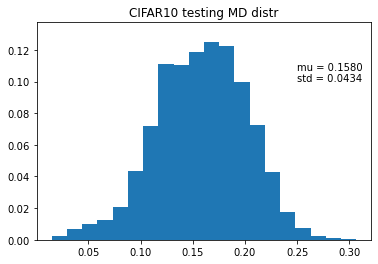

In [45]:
x, bins, p = plt.hist(min_d, bins=20, density=True)
max_height = 0
for item in p:
    h = item.get_height()/sum(x)
    max_height = max(h, max_height)
    item.set_height(h)
plt.ylim((0, max_height * 1.1))
plt.text(0.25, 0.1, f'mu = {min_d.mean():.4f}\nstd = {min_d.std():.4f}')
plt.title('CIFAR10 testing MD distr')
plt.savefig('cifar10_test_md_distr.pdf', bbox_inches='tight')

### calculate FID
cifar10_test_fid = 3.1517648551200637

In [14]:
train_mu, train_std = get_stats(train_feats)
test_mu, test_std = get_stats(test_feats)
print(train_mu.shape, train_std.shape, test_mu.shape, test_std.shape)

(2048,) (2048, 2048) (2048,) (2048, 2048)


In [15]:
cifar_test_fid = calculate_frechet_distance(test_mu, test_std, train_mu, train_std)
print(cifar_test_fid)

3.1517648551200637
